## **Setup & Dependencies**

In [1]:
import os
# Find the latest version of spark 3.0  from http://www-us.apache.org/dist/spark/ and enter as the spark version
# For example:
spark_version = 'spark-3.0.1'
#spark_version = 'spark-3.0.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Fetched 252 kB in 2s (115 kB/s

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import NaiveBayes

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sb
import seaborn as sns; sns.set()

### Start Session and Load Data

In [3]:
# Start Spark session
spark = SparkSession.builder.appName("NaiveBayes").getOrCreate()

In [4]:
# Load and show training dataset from Kaggle.com
train_df = spark.read.csv("./train.csv", inferSchema= True, header = True)
train_df.show()

+---+-------+--------+--------------------+------+
| id|keyword|location|                text|target|
+---+-------+--------+--------------------+------+
|  1|   null|    null|Our Deeds are the...|     1|
|  4|   null|    null|Forest fire near ...|     1|
|  5|   null|    null|All residents ask...|     1|
|  6|   null|    null|13,000 people rec...|     1|
|  7|   null|    null|Just got sent thi...|     1|
|  8|   null|    null|#RockyFire Update...|     1|
| 10|   null|    null|#flood #disaster ...|     1|
| 13|   null|    null|I'm on top of the...|     1|
| 14|   null|    null|There's an emerge...|     1|
| 15|   null|    null|I'm afraid that t...|     1|
| 16|   null|    null|Three people died...|     1|
| 17|   null|    null|Haha South Tampa ...|     1|
| 18|   null|    null|#raining #floodin...|     1|
| 19|   null|    null|#Flood in Bago My...|     1|
| 20|   null|    null|Damage to school ...|     1|
| 23|   null|    null|      What's up man?|     0|
| 24|   null|    null|       I 

In [5]:
# Review schema
train_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- keyword: string (nullable = true)
 |-- location: string (nullable = true)
 |-- text: string (nullable = true)
 |-- target: integer (nullable = true)



## **Data Cleaning and Transformation**

In [6]:
# Remove null values from dataset
trainer_df = train_df.dropna()

In [7]:
# Create a label column 
trainer_df = trainer_df.withColumn("label",col('target'))

In [8]:
# Create all the features to the data set
tokenizer = Tokenizer(inputCol="text", outputCol="token_text")
stopremove = StopWordsRemover(inputCol='token_text',outputCol='stop_tokens')
hashingTF = HashingTF(inputCol="stop_tokens", outputCol='hash_token')
idf = IDF(inputCol='hash_token', outputCol='idf_token')

In [9]:
# Create feature vectors
clean_up = VectorAssembler(inputCols=['idf_token'], outputCol='features')

In [10]:
# Create a and run a data processing Pipeline
data_prep_pipeline = Pipeline(stages=[tokenizer, stopremove, hashingTF, idf, clean_up])

In [11]:
# Fit and transform the pipeline
cleaner_train = data_prep_pipeline.fit(trainer_df)
cleaned_train = cleaner_train.transform(trainer_df)

In [12]:
# Show label and resulting features
cleaned_train.show(5)

+---+-------+--------------------+--------------------+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
| id|keyword|            location|                text|target|label|          token_text|         stop_tokens|          hash_token|           idf_token|            features|
+---+-------+--------------------+--------------------+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
| 48| ablaze|          Birmingham|@bbcmtd Wholesale...|     1|    1|[@bbcmtd, wholesa...|[@bbcmtd, wholesa...|(262144,[112599,1...|(262144,[112599,1...|(262144,[112599,1...|
| 49| ablaze|Est. September 20...|We always try to ...|     0|    0|[we, always, try,...|[always, try, bri...|(262144,[15067,79...|(262144,[15067,79...|(262144,[15067,79...|
| 50| ablaze|              AFRICA|#AFRICANBAZE: Bre...|     1|    1|[#africanbaze:, b...|[#africanbaze:, b...|(262144,[27544,87...

### Model Transformation and Evaluation

In [13]:
# Break data down into a training set and a testing set
training, testing = cleaned_train.randomSplit([0.7, 0.3])

In [14]:
# Create a Naive Bayes model and fit training data
nb = NaiveBayes()
predictor = nb.fit(training)

In [15]:
# Tranform the model with the testing data
test_results = predictor.transform(testing)
test_results.show(5)

+-----+--------+--------------------+--------------------+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|   id| keyword|            location|                text|target|label|          token_text|         stop_tokens|          hash_token|           idf_token|            features|       rawPrediction|         probability|prediction|
+-----+--------+--------------------+--------------------+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|  100|accident|                  UK|http://t.co/GKYe6...|     0|    0|[http://t.co/gkye...|[http://t.co/gkye...|(262144,[8538,387...|(262144,[8538,387...|(262144,[8538,387...|[-774.65364876760...|[1.53266894479837...|       1.0|
|10003| tsunami|BROKE NIGGAS DREAM!!|I want some tsuna...|     0|    0|[i, want,

In [16]:
# Use the Class Evaluator for a cleaner description
acc_eval = MulticlassClassificationEvaluator()
acc = acc_eval.evaluate(test_results)
print("Accuracy of model at predicting disaster tweets was: %f" % acc)

Accuracy of model at predicting disaster tweets was: 0.752726


## **Data Visualization**

In [17]:
# Convert target and prediction results to Pandas dataframe
results_df = test_results.select("target", "prediction").toPandas()
results_df.head()

,target,prediction
0,0,1.0
1,0,0.0
2,0,1.0
3,0,0.0
4,0,0.0


In [18]:
# Convert prediction data to integer
results_df['prediction'] = results_df['prediction'].astype(int)
results_df.head()

,target,prediction
0,0,1
1,0,0
2,0,1
3,0,0
4,0,0


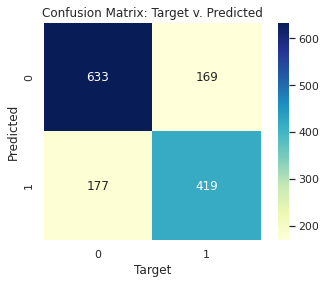

In [19]:
# Create confusion matrix between target and predicted data
matrix = confusion_matrix(results_df.target, results_df.prediction)
sns.heatmap(matrix.T, square=True, annot=True, fmt='d', cmap="YlGnBu")
plt.title('Confusion Matrix: Target v. Predicted')
plt.xlabel('Target')
plt.ylabel('Predicted');

In [20]:
# Create summary dataframe of target and prediction results
tar_total = results_df["target"].value_counts()
pred_total = results_df["prediction"].value_counts()

totals_df = pd.DataFrame({"Target": tar_total,
                          "Prediction": pred_total})
totals_data = totals_df.set_index(pd.Index(['No Disaster', 'Disaster']))

totals_data

,Target,Prediction
No Disaster,810,802
Disaster,588,596


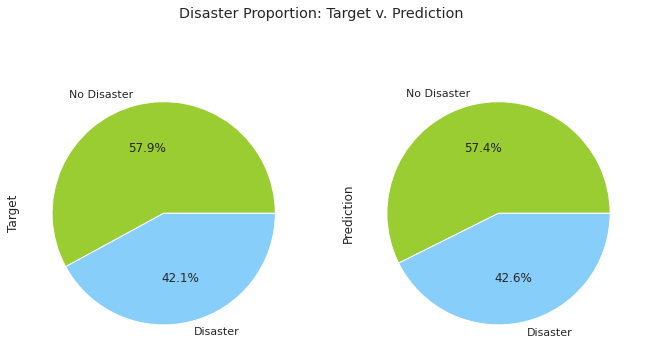

In [21]:
# Display result summary as pie charts
colors = ["yellowgreen", "lightskyblue"]
plot = totals_data.plot.pie(subplots=True, colors=colors, figsize=(11, 6), autopct="%1.1f%%", 
                          startangle=0, title='Disaster Proportion: Target v. Prediction', legend = None)

In [22]:
# Isolate keywords from cleaned trainiing dataset
keywords = cleaned_train.select("keyword").toPandas()

In [23]:
# Clean up keyword strings
keyword_df = keywords['keyword'].str.replace('%20', ' ')

In [24]:
# Count number of keyword occurences
data = keyword_df.value_counts()

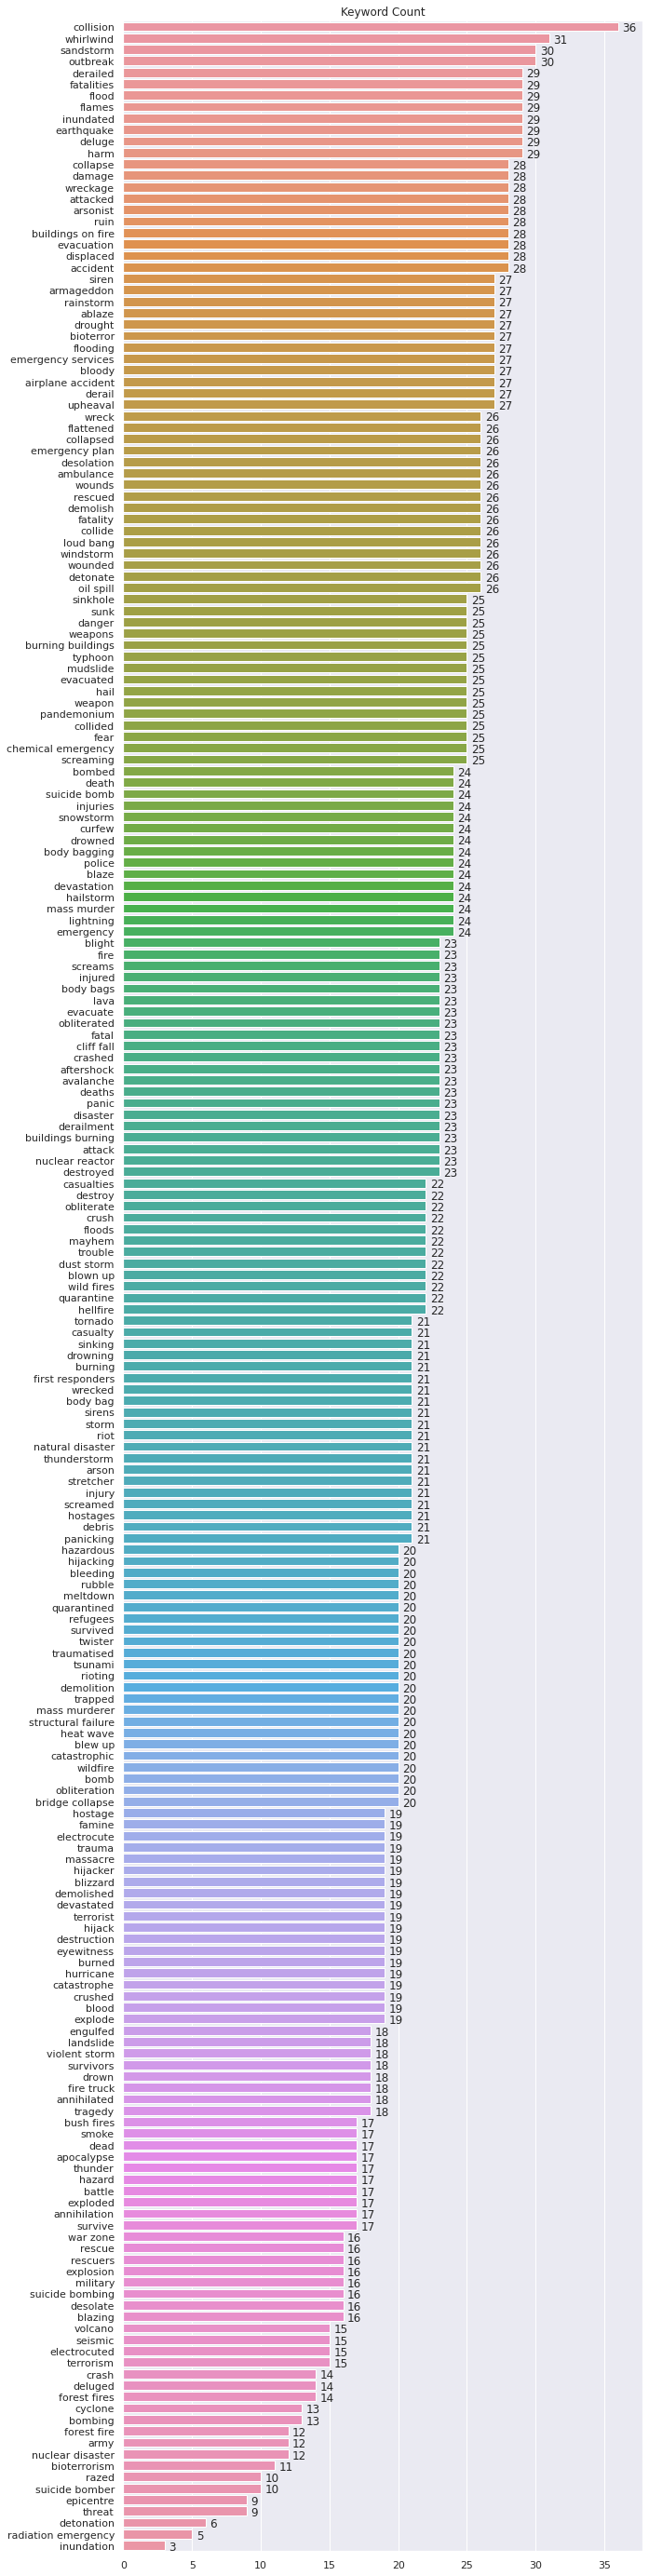

In [25]:
# Create seaborn barplot with keyword data
plt.subplots(figsize=(10,50))
ax = sns.barplot(y = data.index, x = data.values);
ax.set_title('Keyword Count');

# Display bar plot values for each bar
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
show_values_on_bars(ax, "h", 0.3)